## Creating a base level notebook to implement what I learn from the IBM Capstone Project.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(10,6), dpi=180)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


<Figure size 1800x1080 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [3]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [4]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
train.dtypes

Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

In [6]:
train.isnull().sum()

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [7]:
test.isnull().sum()

Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [8]:
num_cols = test.select_dtypes(include='float64').columns.to_list()
cat_cols = test.select_dtypes(include='object').columns.to_list()

In [9]:
cat_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_transformer = SimpleImputer(strategy='median')

In [10]:
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),    
])

In [11]:
train['Personality'] = train['Personality'].map({'Extrovert': 1, 'Introvert': 0})


In [12]:
X = train.copy()
y = X.pop('Personality')

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2)

In [14]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"

    cm = confusion_matrix(y, y_predict)
    plt.figure(figsize=(10, 6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Introvert', 'Extrovert']); ax.yaxis.set_ticklabels(['Introvert', 'Extrovert']) 
    plt.show() 

In [15]:
cv = StratifiedKFold(n_splits=10, random_state=2, shuffle=True)

In [16]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()),
])

In [17]:
param_grid = {'pca__n_components': [2, 3],
              'knn__n_neighbors': [3, 5, 7],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'knn__p': [1, 2]
             }

In [18]:
best_model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy')

In [19]:
best_model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['Time_spent_Alone',
                                                                          'Social_event_attendance',
                                                                          'Going_outside',
                                                                          'Friends_circle_size',
                                                                          'Post_frequency']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Stage_fear',
                                                                          'Drained_after_socializing'])])),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2],
                         'pca__n_components': [2, 3]},
             scoring='accuracy')

In [20]:
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)
print("accuracy :", best_model.best_score_)

tuned hpyerparameters :(best parameters)  {'knn__algorithm': 'auto', 'knn__n_neighbors': 7, 'knn__p': 2, 'pca__n_components': 2}
accuracy : 0.9670329567879173


In [21]:
accuracy_knn = best_model.score(X_valid, y_valid)
print("Test set score: {:.6f}".format(accuracy_knn))

Test set score: 0.970201


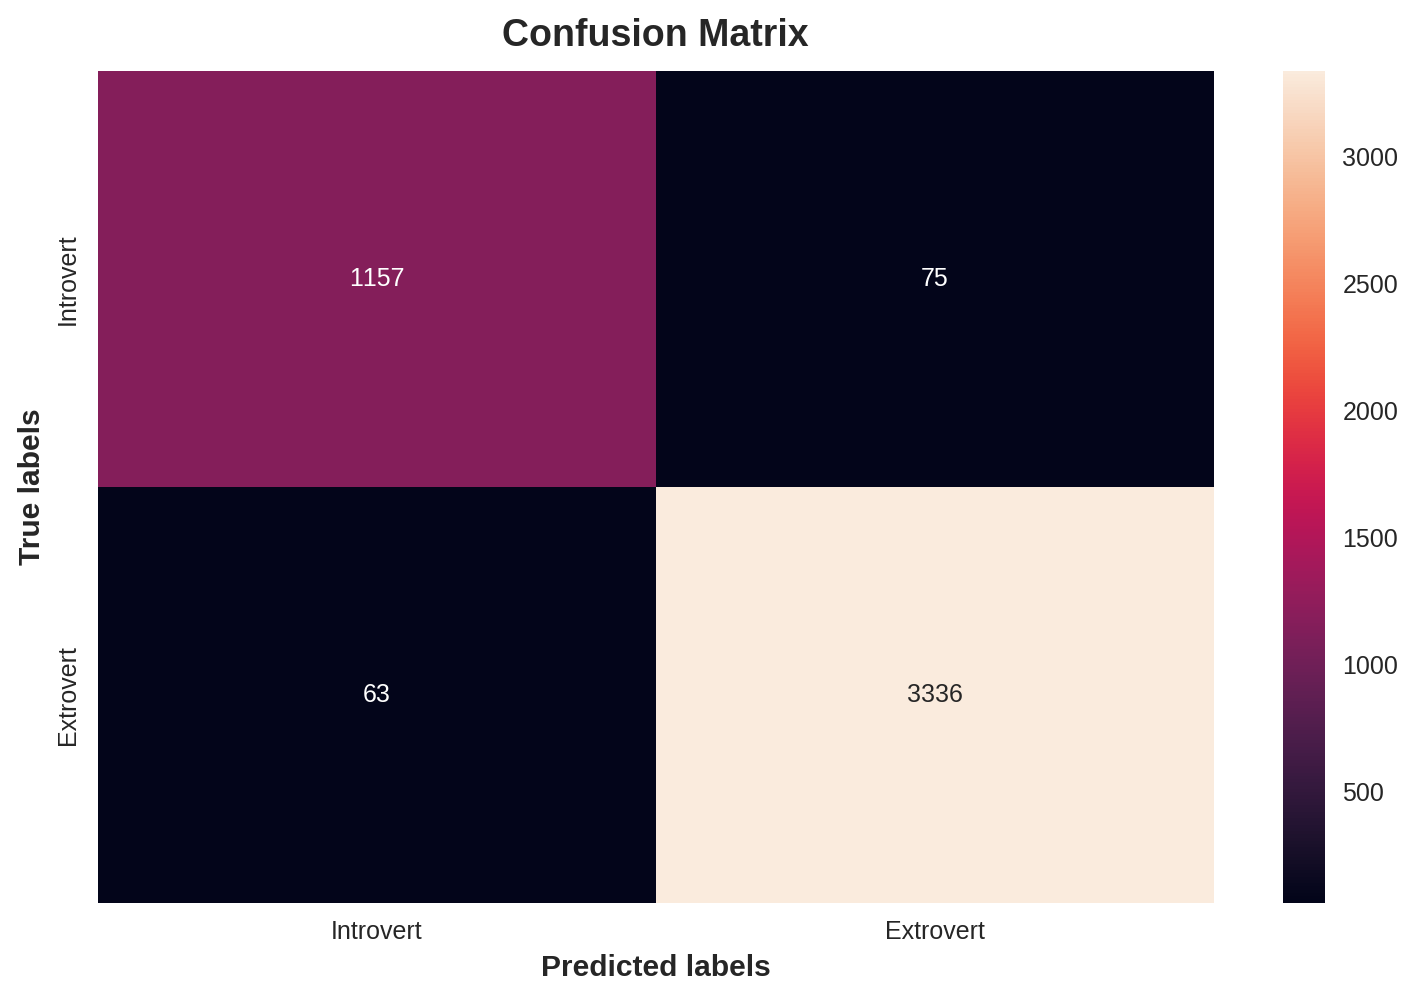

In [22]:
yhat_knn = best_model.predict(X_valid)
plot_confusion_matrix(y_valid, yhat_knn)

In [23]:
X_test = test.copy()

In [24]:
knn_test = best_model.predict_proba(X_test)
final_preds = np.argmax(knn_test, axis=1)
final_preds = pd.Series(final_preds)

In [25]:
knn_test = final_preds.map({1: 'Extrovert', 0: 'Introvert'})

In [26]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')
sub['Personality'] = knn_test
sub.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")
sub.head()

Submission file saved as submission.csv


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
